# 手把手教你写决策树

数据来源于我的Github项目。

https://github.com/juwikuang/china_job_survey

我爬了全国的招聘信息，然后以上海为例子，选择了收入最高的25%和最低的25%，以他们作为两类。通过机器学习的分类模型，找出程序员如何成功（成为收入最高的25%）的秘诀。
最近正好朋友介绍了一本书，成功的公式。它也是通过大量数据，找出成功的公式的。我决心好好分析数据，找出程序员成功的Formula。

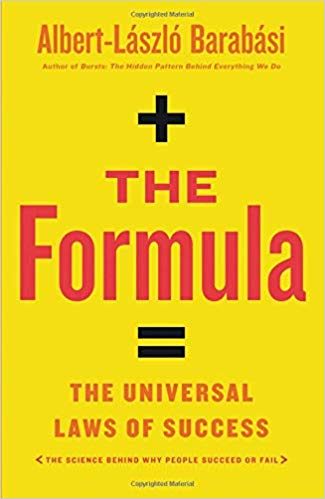

In [1]:
from IPython.display import Image
Image(open("./data/formula.png",mode='rb').read())

In [2]:
import pickle
import numpy as np
import pandas as pd
import random
random.seed(100)

In [3]:
data = pickle.load(open('./data/shanghai_experience_3_5.dmp', mode='rb'))

dataset 说明，

low=工资是否低，low=0表示高工资，low=1表示低工资。这是我们的label，或者说y，或者叫应变量。其他的叫features，或者叫X，或者叫自变量。

注意我这里y是小写，X是大写，因为y是vector，X是matrix

ageism=是否有年龄歧视，我检查招聘信息里面，是否有【岁】字，是则是年龄歧视。

career_algorithm, career_architect, career_software_engineer=这里对职业（career），进行了one-hot-encoding。

其他100多个feature就不一一解释了。这里并不是写论文，等他们出现了再说。

为了简单起见，所有的feature都是bool型的

In [4]:
data.head()

,ageism,career_algorithm,career_architect,career_software_engineer,company_size_10000,company_size_1000_5000,company_size_150_500,company_size_50,company_size_5000_10000,company_size_500_1000,...,ml_mxnet,ml_chainer,ml_keras,ml_deeplearning4j,ml_theano,ml_sklearn,ml_mahout,ml_paddlepaddle,career_spider,low
0,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
1,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
2,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
3,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
4,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1


In [5]:
data.describe()

,low
count,4891.000000
mean,0.541198
std,0.498351
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [6]:
data.shape

(4891, 128)

# 决策树

决策树Decision Tree(DT)，是通过某种选择机制（entropy或者gini），找到能够把数据分成正负两组的特征。往往需要多次划分，才能得到满意的结果，所以，最后得到的模型，看起来就像一颗树。所以叫决策树。

这个算法，概括的来说，就是不断的寻找一个最优解（最优特征+最优分割点），把数据集一分为二，使集合纯度最高（label为true的和false尽量分开），直到分了n层。

具体来说，就是：

加载数据，遍历每个特征，用每个特征去划分数据集。

这里的特征，可能是bool型的，那就最好了，true的一组，false的一组，直接分成了两组。

也可能是数值型的，那就要把数据从小到大排序，不断的增大切割点的数值，只到找到最优的解。

如果特征是字典型的（categorical，如天气分为晴天，阴天，下雨）的，现在一般是用one-hot-encoding转化成几个bool型。

每个特征的最优解，都是用entropy或者gini表示的，等遍历完了所有的特征，就比较他们的entrop或者gini，选出最优的。

用最优解把数据集一分为二，再对子数据集运用上面的步骤，直到决策树已经达到了一定深度。


# 集合纯度
集合纯度是决策树的难点重点，我们需要找到一种数学方法，去计算集合的纯度。常用的有熵（entropy）和基尼（gini）

## Entropy
根据维基百科，信息熵（Information Entropy）的数学定义为：

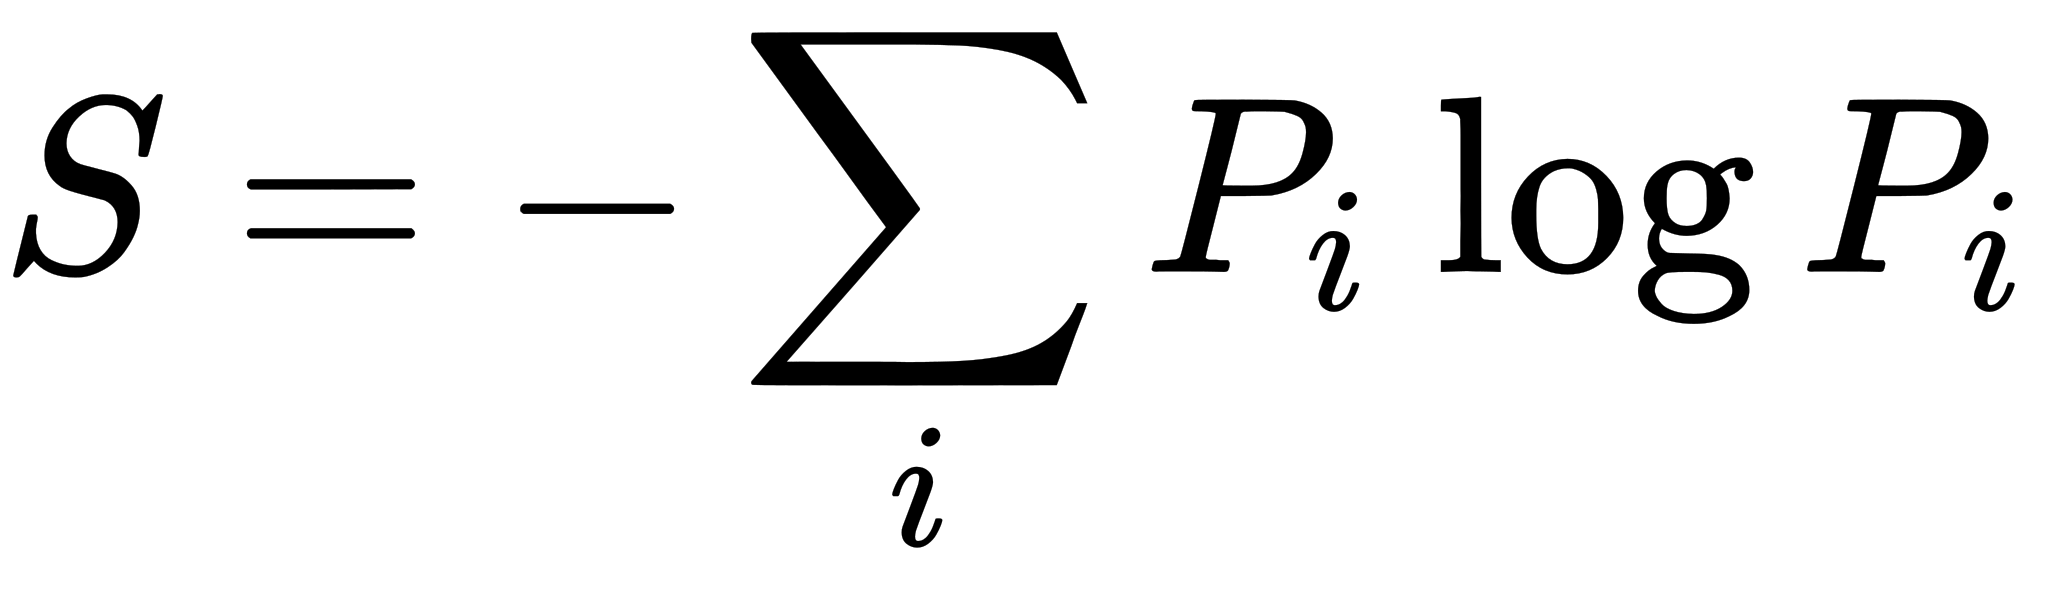

In [51]:
from IPython.core.display import SVG
SVG(filename='./data/entropy.svg')

In [8]:
def information_entropy(counts):
    percentages = counts/np.sum(counts)
    S=0
    for p in percentages:
        if p==0:
            continue
        S=S-(p*np.log2(p))
    return S

这里p表示百分比，S表示信息熵。S越小，数据集的纯度越高。

以我们的数据集为例，假如所有人都是高收入，则S等于0，这时S最小，数据集最纯。

In [9]:
information_entropy([0,1])

0.0

假如所有人都是假如高低收入各半，则S等于1，这时S最大，数据集最不纯。

In [10]:
information_entropy([1/2,1/2])

1.0

那实际情况呢？我们算一下

我们看看我们的数据集的information entropy

In [11]:
n_low=np.sum(data.low==1)
n_low

2647

In [12]:
n_high=data.shape[0]-n_low
n_high

2244

In [13]:
n_rows = data.shape[0]
n_rows

4891

In [14]:
p_low=n_low/n_rows
p_low

0.5411981189940708

In [15]:
p_high=1-p_low
p_high

0.4588018810059292

In [16]:
S=-p_low*np.log2(p_low)-p_high*np.log2(p_high)

In [17]:
S

0.9950971141240397

In [18]:
information_entropy([n_low, n_high])

0.9950971141240397

可见，信息熵接近于1，说明我们数据集的纯度非常低。

假如我们用会不会python，把数据集切开。

In [19]:
data_python=data[data.pl_python==1]
data_not_python=data[~data.pl_python==1]

接着，我们分别计算这两组的信息熵

In [20]:
def data_entropy(data):
    n_rows=data.shape[0]
    n_low=data[data.low==1].shape[0]
    n_high=n_rows-n_low
    return information_entropy([n_low, n_high])

In [21]:
entropy_python=data_entropy(data_python)
entropy_python

0.889729694070529

In [22]:
entropy_not_python=data_entropy(data_not_python)
entropy_not_python

0.9810034249081002

我们把上面的两个组的熵，按照他们占原数据集的比例，计算出新平均的信息熵如下：

In [23]:
S_new = data_python.shape[0]/data.shape[0] * entropy_python + data_not_python.shape[0]/data.shape[0] * entropy_not_python
S_new

0.9677537113741245

In [24]:
def data_entropy2(data1, data2):
    entrop1=data_entropy(data1)
    entrop2=data_entropy(data2)
    n1=data1.shape[0]
    n2=data2.shape[0]
    n=n1+n2
    return n1/n*entrop1+n2/n*entrop2

In [25]:
data_entropy2(data_python, data_not_python)

0.9677537113741245

可见，我们用学历去划分数据集以后，信息熵变小了，既数据集更纯了。而变小的程度可以用两者的差值表示，既：

In [26]:
Gain=S-S_new
Gain

0.027343402749915202

我们把这个差值叫做信息增益。我们每次切割数据集，就是要找出这样一个特征，以它划分数据集，得到的信息增益Gain最大。

现在我们可以去遍历所有的特征，看看谁的Gain最大。

In [27]:
def find_best_feature(data, label):
    X=data.drop(label, axis=1)
    min_entropy=1
    col_selected=''
    data_positive_found=None
    data_negative_found=None
    for col in X.columns:
        data_positive=data[data[col]==1]
        data_negative=data[data[col]==0]
        if data_positive.shape[0]==0:
            continue
        if data_negative.shape[0]==0:
            continue
        entropy=data_entropy2(data_positive, data_negative)
        #print(gain,entropy,entropy_new)
        if entropy<min_entropy:
            min_entropy=entropy
            col_selected=col
            data_positive_found=data_positive
            data_negative_found=data_negative
    return col_selected, min_entropy, data_positive_found, data_negative_found

In [28]:
result=find_best_feature(data, 'low')

In [29]:
gain=S-result[1]
gain

0.06206312569344985

In [30]:
print(result[0])

edu_associate


In [31]:
data.shape

(4891, 128)

这里，我们得到了，获得高薪的最主要因素，学历！既然这里出现学历了，说明一下我们的数据集包含四种学历（大专，本科，硕士，博士）。associate这个单词表示大专。


In [32]:
data_associate=data[data.edu_associate==1]
data_associate[data_associate.low==0].shape[0]/data_associate.shape[0]

0.23500352858151025

In [33]:
data_not_associate=data[data.edu_associate==0]
data_not_associate[data_not_associate.low==0].shape[0]/data_not_associate.shape[0]

0.5500863557858376

计算可知在大专学历的人中，31%获得高薪，而在大专以上的人中69%获得高薪。

由此可见，学历高于大专，是获得高薪的最重要因素。
【谁说读书没有用】

## 基尼系数Gini Impurity
我们也可以用Gini Impurity来判断。这里只给出公式。假设有两个组，平均分配，则Gini Impurity是1-(1/2)^2-(1/2)^2=1/2。而如果全部分配到一边1-0-1=0.所以，gini impurity越小，数据纯度越高。所以它不叫purity（纯度），而叫Impurity（不纯度）。

图片来源于Wikipedia

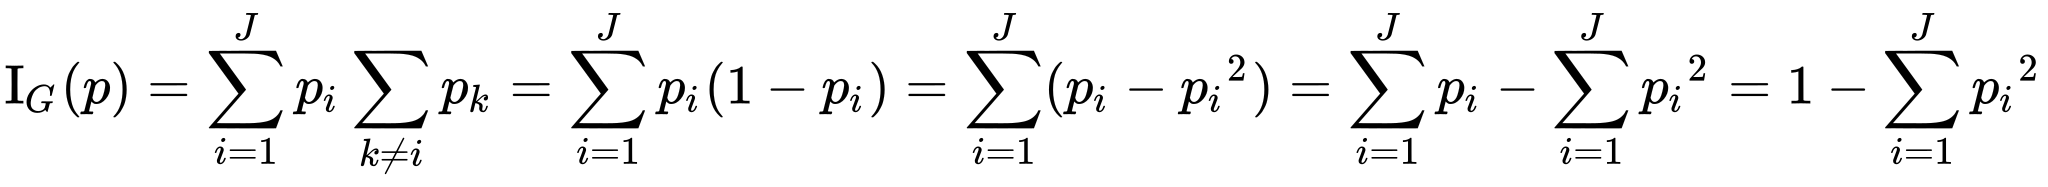

In [50]:
SVG(filename='./data/gini_impurity.svg')

In [52]:
def gini_impurity(counts):
    p_list=counts/np.sum(counts)
    return 1-np.sum(p_list*p_list)

In [54]:
gini_impurity([0,100])

0.0

In [55]:
gini_impurity([50,50])

0.5

# 决策树算法
有了上面的基础，我们就可以写决策树算法了。

In [34]:
msk = np.random.rand(len(data)) < 0.8
data_train=data[msk]
data_test=data[~msk]
X_train=data_train.drop('low', axis=1)
y_train=data_train.low
X_test=data_test.drop('low', axis=1)
y_test=data_test.low


In [35]:
class Branch:
    no=0
    depth=1
    column=''
    entropy=0
    samples=0
    value=[]
    
    branch_positive=None
    branch_negative=None
    no_positive=0
    no_negative=0

In [36]:
number=0

def decision_tree_inner(data, label, depth, max_depth=3):
    global number
    branch = Branch()
    branch.no=number
    number=number+1
    branch.depth=depth
    
    branch.samples=data.shape[0]
    n_positive=data[data[label]==1].shape[0]
    branch.value=[branch.samples-n_positive,n_positive]
    branch.entropy=information_entropy(branch.value)
    best_feature = find_best_feature(data, label)
    branch.column=best_feature[0]
    new_entropy=best_feature[1]
    if depth==max_depth or branch.column=='':
        branch.no_positive=number
        number=number+1
        branch.no_negative=number
        number=number+1
        return branch
    else:
        data_negative=best_feature[3]
        branch.branch_negative=decision_tree_inner(data_negative, label, depth+1, max_depth=max_depth)
        data_positive=best_feature[2]
        branch.branch_positive=decision_tree_inner(data_positive, label, depth+1, max_depth=max_depth)

        return branch

def decision_tree(data, label, max_depth=3):
    number=0
    entropy=data_entropy(data)
    tree=decision_tree_inner(data, label, 0, max_depth=3)
    return tree

In [37]:
my_dt = decision_tree(data_train, 'low', max_depth=2)

以下代码用来可视化decision tree，

In [38]:
def get_dot_data_innner(branch:Branch, classes, dot_data):
    if branch.value[0]<branch.value[1]:
        the_class=classes[0]
    else:
        the_class=classes[1]
    if branch.branch_positive:
        dot_data=dot_data+'{} [label=<{}?<br/>entropy = {:.3f}<br/>samples = {}<br/>value = {}<br/>class = {}> , fillcolor="#FFFFFFFF"] ;\r\n'.format(
            branch.no, branch.column, branch.entropy, branch.samples, branch.value, the_class)
    else:
        dot_data=dot_data+'{} [label=<entropy = {:.3f}<br/>samples = {}<br/>value = {}<br/>class = {}> , fillcolor="#FFFFFFFF"] ;\r\n'.format(
            branch.no, branch.entropy, branch.samples, branch.value, the_class)
    if branch.branch_negative:
        dot_data=dot_data+'{} -> {} [labeldistance=2.5, labelangle=45, headlabel="no"]; \r\n'.format(branch.no, branch.branch_negative.no)
        dot_data=get_dot_data_innner(branch.branch_negative, classes, dot_data)
        
    if branch.branch_positive:
        dot_data=dot_data+'{} -> {} [labeldistance=2.5, labelangle=45, headlabel="yes"]; \r\n'.format(branch.no, branch.branch_positive.no)
        dot_data=get_dot_data_innner(branch.branch_positive, classes, dot_data)
  

    return dot_data
    
def get_dot_data(branch:Branch, classes=['low','high']):
    dot_data="""
digraph Tree {
node [shape=box, style="filled, rounded", color="black", fontname=helvetica] ;
edge [fontname=helvetica] ;
"""
    dot_data=get_dot_data_innner(branch, classes,  dot_data)
    dot_data=dot_data+'\r\n}'
    return dot_data

In [58]:
dot_data=get_dot_data(my_dt)

In [59]:
#print(dot_data)

In [60]:
import graphviz 

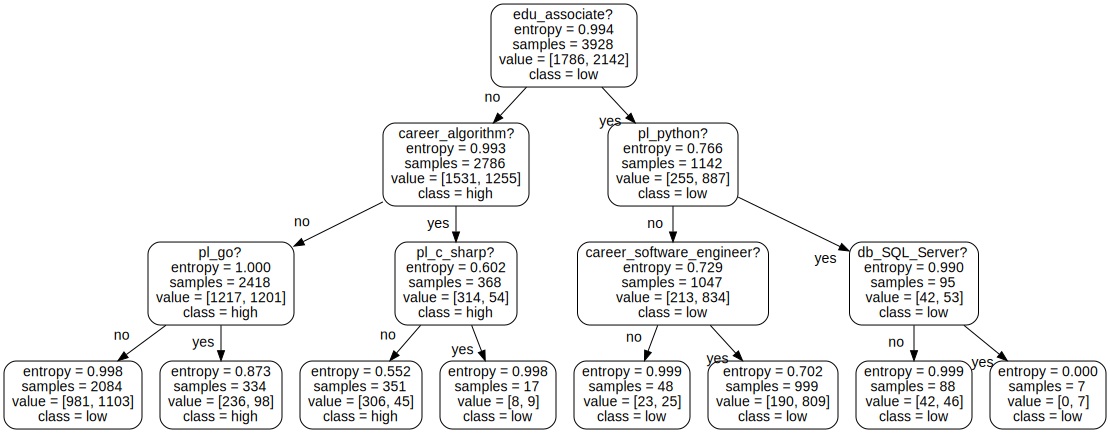

In [62]:
graph = graphviz.Source(dot_data) 
graph.render('./data/my_dt', format='png')
graph

# 验证

In [43]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion='entropy', max_depth=3)
model=dt.fit(X_train, y_train)

In [44]:
model.score(X_train, y_train)

0.6468940936863544

In [45]:
model.score(X_test, y_test)

0.612668743509865

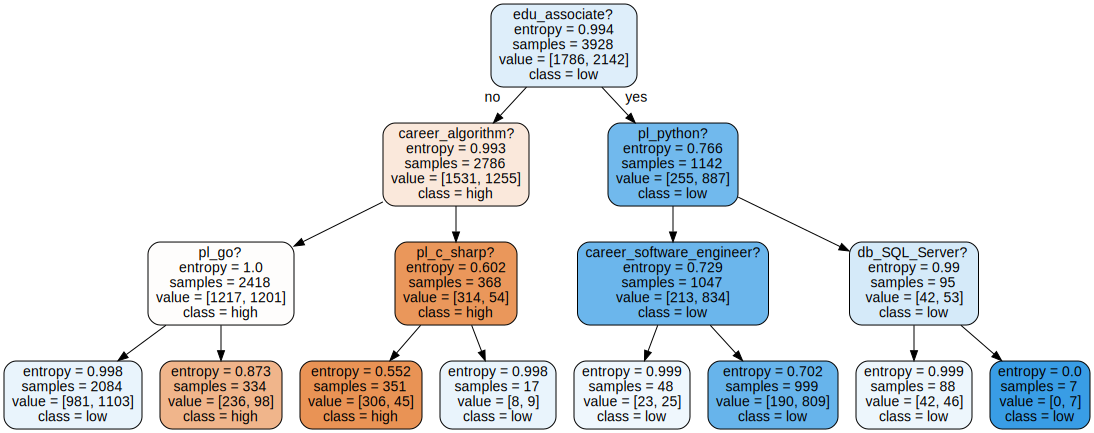

In [63]:
from sklearn import tree
import graphviz 
dot_data = tree.export_graphviz(model, out_file=None, 
                      feature_names=X_train.columns,  
                      class_names=['high','low'],  
                      filled=True, rounded=True,  
                      special_characters=True)  
new_dot_data=dot_data.replace('True','no').replace('False','yes').replace(' &le; 0.5','?')
graph = graphviz.Source(new_dot_data) 
graph.render('./data/dt_sklearn', format='png')
graph

# Reference
https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity